# Install Dependencies

In [ ]:
!pip install tensorflow==2.10.0

In [ ]:
!pip install tensorflow-gpu==2.10.0

In [ ]:
!pip install opencv-python

In [ ]:
!pip install matplotlib

# Import Dependencies

In [35]:
#importing standard dependencies

import cv2
import os
import random
import time
import numpy as np
import requests
from matplotlib import pyplot as plt

In [ ]:
#imporing tensorflow dependencies - Functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


# Set GPU Growth

#### This is to avoid the out of memory error and limit the GPU usage
#### If memory growth is enabled for a PhysicalDevice, the runtime initialization will not allocate all memory on the device.

In [ ]:
#check the number of available GPU and also check if tensorflow is detecting it
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

In [ ]:
#getting the details of the GPU
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
#setting memory growth for GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# Create folder structure

In [ ]:
import tempfile

temp_dir = tempfile.gettempdir() # retrieves the system's temporary directory

temp_dir

In [ ]:
# Setup paths in temp dir
POS_PATH = os.path.join(temp_dir,'data', 'positive')
NEG_PATH = os.path.join(temp_dir,'data', 'negative')
ANC_PATH = os.path.join(temp_dir,'data', 'anchor')

print("Positive path: ",POS_PATH)
print("Negative path: ",NEG_PATH)
print("Anchor path: ",ANC_PATH)

In [ ]:

# Make the directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)

# Collect Positives,Negatives and Anchors

#### Negatives collection from existing dataset

In [41]:
from urllib import request

url = "https://figshare.com/ndownloader/files/5976018/lfw.tgz"
target_path = os.path.join(NEG_PATH,"lfw.tgz")

with request.urlopen(request.Request(url), timeout=15.0) as response:
    if response.status == 200:
        with open(target_path, "wb") as f:
            f.write(response.read())

In [43]:
import tarfile

def uncompress_tar(tar_filepath, extract_path):
    try:
        with tarfile.open(tar_filepath, 'r') as tar:
            tar.extractall(path=extract_path)
        print(f"Successfully extracted '{tar_filepath}' to '{extract_path}'")
    except FileNotFoundError:
        print(f"Error: Tar file '{tar_filepath}' not found.")
    except tarfile.ReadError as e:
         print(f"Error: Could not open '{tar_filepath}'. It may be corrupted or not a valid tar file. Details: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

In [45]:
uncompress_tar(target_path,NEG_PATH)

Successfully extracted 'C:\Users\Utsav\AppData\Local\Temp\data\negative\lfw.tgz' to 'C:\Users\Utsav\AppData\Local\Temp\data\negative'


In [49]:
import shutil
# removing the tar and extracted folder from NEG_PATh
#os.remove(target_path)
shutil.rmtree(os.path.join(NEG_PATH,"lfw"))

#### Positive collection from webcam

In [50]:
# importing uuid library to geenrate unique image names
import uuid

In [51]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 15

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

#### Anchor collection from webcam

In [52]:
cap = cv2.VideoCapture(0)

# Set the capture duration to 5 minutes (300 seconds)
capture_duration = 15

# Record start time
start_time = time.time()

while(int(time.time() - start_time) < capture_duration):
    ret, frame = cap.read()

    #to capture only 250x250px to make all images a standard size
    frame = frame[120:120+250,200:200+250,:]

    #to rectify the lateral inversion
    flipped_frame = cv2.flip(frame, 1)

    cv2.waitKey(1)

    # Create the unique file path 
    imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
    
    # Write out anchor image
    cv2.imwrite(imgname, frame)

    cv2.imshow('Image collection',flipped_frame)
   

cap.release()
cv2.destroyAllWindows()

# Data Augmentation

In [53]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [54]:
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [55]:
for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# Load and Preprocess Images

#### Get images directories

In [56]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [57]:
dir_test = anchor.as_numpy_iterator()

In [58]:
#to check if the iterator is reading all the imaage path
print(dir_test.next())

b'C:\\Users\\Utsav\\AppData\\Local\\Temp\\data\\anchor\\39c20616-35d7-11f0-9547-000d3af0c63d.jpg'


#### Preprocessing - Scale and Resize

In [59]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [60]:
img = preprocess(dir_test.next())

In [61]:
img.numpy()

array([[[0.9166667 , 0.94411767, 0.9127451 ],
        [0.91568625, 0.9431372 , 0.9117647 ],
        [0.91495097, 0.94240195, 0.9110294 ],
        ...,
        [0.91568625, 0.9431372 , 0.91568625],
        [0.9110294 , 0.9406863 , 0.9125    ],
        [0.90588236, 0.94509804, 0.9137255 ]],

       [[0.9120098 , 0.93921566, 0.8901961 ],
        [0.9112745 , 0.9384804 , 0.8894608 ],
        [0.9115196 , 0.9343137 , 0.89117646],
        ...,
        [0.9117647 , 0.92941177, 0.904902  ],
        [0.91568625, 0.93333334, 0.90882355],
        [0.9193627 , 0.93897057, 0.9137255 ]],

       [[0.9144608 , 0.9242647 , 0.8693628 ],
        [0.9196078 , 0.92941177, 0.8745098 ],
        [0.9254902 , 0.9352941 , 0.88039213],
        ...,
        [0.9237745 , 0.9355392 , 0.9080882 ],
        [0.9193627 , 0.9311274 , 0.90367645],
        [0.91764706, 0.92941177, 0.9019608 ]],

       ...,

       [[0.30416667, 0.32083333, 0.3139706 ],
        [0.27107844, 0.2877451 , 0.28088236],
        [0.2509804 , 0

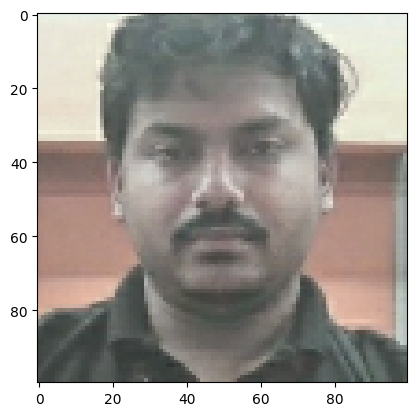

In [62]:
#to check the scaling is working. We will see the image size should be 100x100px
plt.imshow(img)

#### Create Labelled Dataset

In [63]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [64]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [65]:
samples = data.as_numpy_iterator()

In [66]:
example = samples.next()

In [67]:
example

(b'C:\\Users\\Utsav\\AppData\\Local\\Temp\\data\\anchor\\39c169ca-35d7-11f0-a1fb-000d3af0c63d.jpg',
 b'C:\\Users\\Utsav\\AppData\\Local\\Temp\\data\\positive\\43fbb4dc-35d7-11f0-9106-000d3af0c63d.jpg',
 1.0)

#### Build Train and Test Partition

In [68]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [69]:
res = preprocess_twin(*example)

In [70]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.8980392 , 0.9254902 , 0.8980392 ],
         [0.8980392 , 0.9254902 , 0.8980392 ],
         [0.8980392 , 0.9254902 , 0.8980392 ],
         ...,
         [0.89411765, 0.93333334, 0.9019608 ],
         [0.8931373 , 0.93235296, 0.9009804 ],
         [0.89411765, 0.93333334, 0.9019608 ]],
 
        [[0.89509803, 0.92058825, 0.8931373 ],
         [0.89509803, 0.92058825, 0.8931373 ],
         [0.89411765, 0.9196078 , 0.89215684],
         ...,
         [0.8982843 , 0.922549  , 0.8901961 ],
         [0.8977941 , 0.91764706, 0.8872549 ],
         [0.9007353 , 0.92058825, 0.8901961 ]],
 
        [[0.9009804 , 0.92058825, 0.8931373 ],
         [0.9009804 , 0.92058825, 0.8931373 ],
         [0.89730394, 0.9169118 , 0.8894608 ],
         ...,
         [0.89411765, 0.90294117, 0.8617647 ],
         [0.89411765, 0.90294117, 0.8617647 ],
         [0.89509803, 0.90392154, 0.8627451 ]],
 
        ...,
 
        [[0.28799018, 0.3115196 

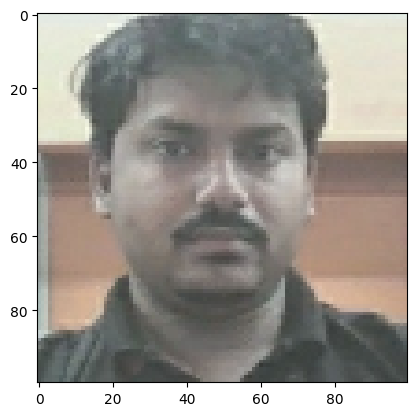

In [71]:
plt.imshow(res[0])

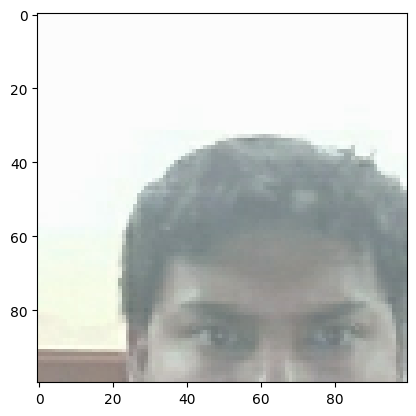

In [72]:
plt.imshow(res[1])

In [73]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [74]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [75]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)